# Vatsal's EDA

![vaccine-image.jpg](Images/head.jpg)
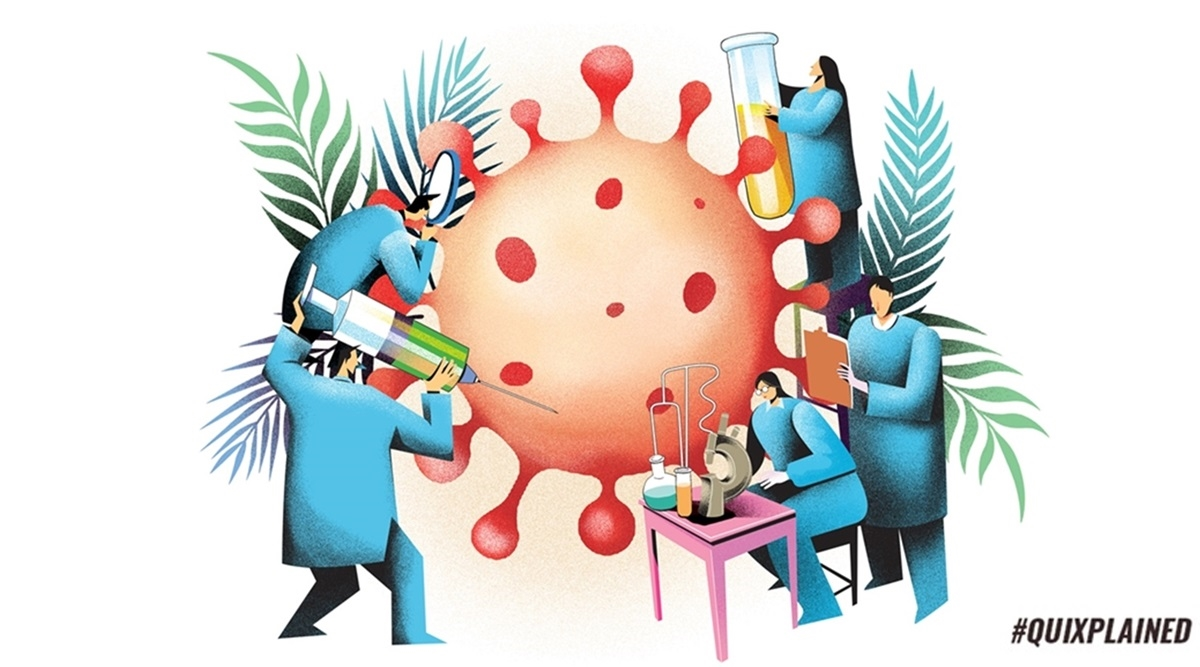

**What do we have**?

We have a subset of an Eterna dataset comprising over 3000 RNA molecules (which span a panoply of sequences and structures) and their degradation rates at each position.

There are multiple ground truth values provided in the training data. While the submission format requires all 5 to be predicted, only the following are scored: reactivity, deg_Mg_pH10, and deg_Mg_50C.
Files

*     train.json - the training data
*     test.json - the test set, without any columns associated with the ground truth.
*     sample_submission.csv - a sample submission file in the correct format

**Columns**

*     `id` - An arbitrary identifier for each sample.

*     `seqscored` - (68 in Train and Public Test, 91 in Private Test) Integer value denoting the number of positions used in scoring with predicted values. This should match the length of reactivity, deg and error* columns. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.

*     `seq_length` - (107 in Train and Public Test, 130 in Private Test) Integer values, denotes the length of sequence. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.

*     `sequence` - (1x107 string in Train and Public Test, 130 in Private Test) Describes the RNA sequence, a combination of A, G, U, and C for each sample. Should be 107 characters long, and the first 68 bases should correspond to the 68 positions specified in seq_scored (note: indexed starting at 0).

*     `structure` - (1x107 string in Train and Public Test, 130 in Private Test) An array of (, ), and . characters that describe whether a base is estimated to be paired or unpaired. Paired bases are denoted by opening and closing parentheses e.g. (....) means that base 0 is paired to base 5, and bases 1-4 are unpaired.

*     `reactivity` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are * reactivity values for the first 68 bases as denoted in sequence, and used to determine the likely secondary structure of the RNA sample.

*     `deg_pH10` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high pH (pH 10).

*     `deg_Mg_pH10` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium in high pH (pH 10).

*     `deg_50C` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high temperature (50 degrees Celsius).

*     `deg_Mg_50C` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium at high temperature (50 degrees Celsius).

*     `error` - An array of floating point numbers, should have the same length as the corresponding reactivity or deg* columns, calculated errors in experimental values obtained in reactivity and deg* columns.

*     `predicted_loop_type` - (1x107 string) Describes the structural context (also referred to as 'loop type')of each character in sequence. Loop types assigned by bpRNA from Vienna RNAfold 2 structure. From the bpRNA_documentation: S: paired "Stem" M: Multiloop I: Internal loop B: Bulge H: Hairpin loop E: dangling End X: eXternal loop

## Install Packages

---
- Reference

    1. [https://anaconda.org/bioconda/viennarna](https://anaconda.org/bioconda/viennarna)
    2. [https://github.com/ViennaRNA/forgi](https://github.com/ViennaRNA/forgi)

In [1]:
%%capture
!pip install forgi
!yes Y |conda install -c bioconda viennarna

## Library Imports

In [2]:
import os, math, random
from collections import Counter

import RNA
import subprocess
from forgi.graph import bulge_graph
import forgi.visual.mplotlib as fvm
from IPython.display import Image, SVG

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from colorama import Fore, Back, Style

ModuleNotFoundError: No module named 'RNA'

## Data Import

In [3]:
path = '/kaggle/input/stanford-covid-vaccine'
train_df = pd.read_json(f'{path}/train.json',lines=True)
test_df = pd.read_json(f'{path}/test.json', lines=True)
sub_df = pd.read_csv(f'{path}/sample_submission.csv')

print('Train set sequences: ', train_df.shape)
print('Test set sequences: ', test_df.shape)

Train set sequences:  (2400, 19)
Test set sequences:  (3634, 7)


## Train Data Overview

In [4]:
train_df.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


## Data Info Method

In [5]:
def data_info(_id, df):
    print(Fore.YELLOW)
    print("ID = ",_id)
    sample_data = df.loc[df['id'] == _id]
    print(Fore.MAGENTA)
    print("Secquence : \n\n",sample_data['sequence'].values[0])
    print(dict(Counter(sample_data['sequence'].values[0])))
    print("Secquence Length : ",len(sample_data['sequence'].values[0]))
    print(Fore.CYAN)
    print("Structure : \n",sample_data['structure'].values[0])
    print(dict(Counter(sample_data['structure'].values[0])))
    print("Structure Length : ",len(sample_data['structure'].values[0]))
    print(Fore.WHITE)
    print("predicted_loop_type : \n\n",sample_data['predicted_loop_type'].values[0])
    print(dict(Counter(sample_data['predicted_loop_type'].values[0])))
    print("predicted_loop_type Length : ",len(sample_data['predicted_loop_type'].values[0]))
    print(Fore.GREEN)
    print("seq_length :",sample_data['seq_length'].values)
    print("seq_scored :",sample_data['seq_scored'].values)
    print(Style.RESET_ALL)

In [6]:
data_info("id_001f94081",train_df)


ID =  id_001f94081

Secquence : 

 GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUAACUGGAAUAACCCAUACCAGCAGUUAGAGUUCGCUCUAACAAAAGAAACAACAACAACAAC
{'G': 19, 'A': 45, 'C': 23, 'U': 20}
Secquence Length :  107

Structure : 
 .....((((((.......)))).)).((.....((..((((((....))))))..)).....))....(((((((....))))))).....................
{'.': 61, '(': 23, ')': 23}
Structure Length :  107

predicted_loop_type : 

 EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHHHSSSSSSIISSIIIIISSXXXXSSSSSSSHHHHSSSSSSSEEEEEEEEEEEEEEEEEEEEE
{'E': 26, 'S': 46, 'H': 15, 'B': 1, 'X': 5, 'I': 14}
predicted_loop_type Length :  107

seq_length : [107]
seq_scored : [68]



## signal_to_noise Histogram

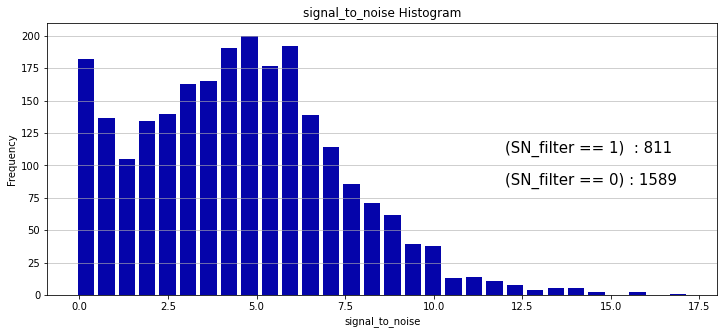

In [7]:
plt.figure(figsize=(12,5))
n, bins, patches = plt.hist(x=train_df['signal_to_noise'], bins='auto', color='#0504aa', alpha=1, rwidth=0.80)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('signal_to_noise')
plt.ylabel('Frequency')
plt.title('signal_to_noise Histogram')
plt.text(12, 110, f"(SN_filter == 1)  : {train_df['SN_filter'].value_counts()[0]}", fontsize=15)
plt.text(12, 85, f"(SN_filter == 0) : {train_df['SN_filter'].value_counts()[1]}", fontsize=15)
plt.show()

In [8]:
train_df.seq_length.value_counts()

107    2400
Name: seq_length, dtype: int64

In [9]:
train_df.seq_scored.value_counts()

68    2400
Name: seq_scored, dtype: int64

## Test Data Overview

In [10]:
test_df.head()

,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [11]:
data_info("id_000ae4237",test_df)


ID =  id_000ae4237

Secquence : 

 GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAUGCAGCUACCGGCUCUAUAAUGAGCAAAAACGGUAAAUCCCGACAAGCUUGAUUUCGAUCAAGCAAAAGAAACAACAACAACAAC
{'G': 26, 'A': 50, 'C': 29, 'U': 25}
Secquence Length :  130

Structure : 
 .....((((..((((((...(((((.....((((....))))....)))))..)))((((......)))).....))).....))))....(((((((....))))))).....................
{'.': 70, '(': 30, ')': 30}
Structure Length :  130

predicted_loop_type : 

 EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIIISSSSSIISSSSSSSHHHHHHSSSSMMMMMSSSIIIIISSSSXXXXSSSSSSSHHHHSSSSSSSEEEEEEEEEEEEEEEEEEEEE
{'E': 26, 'S': 60, 'I': 21, 'H': 14, 'M': 5, 'X': 4}
predicted_loop_type Length :  130

seq_length : [130]
seq_scored : [91]



In [12]:
test_df.seq_length.value_counts()

130    3005
107     629
Name: seq_length, dtype: int64

In [13]:
test_df.seq_scored.value_counts()

91    3005
68     629
Name: seq_scored, dtype: int64

* In Test data seq_length = 107 have seq_scored = 68   #[629]
* In Test data seq_length = 130 have seq_scored = 91   #[3005]

## Detailed Analysis

In [14]:
def character_count(row):
    _dictionary = {'G': 0,'A': 0, 'C': 0, 'U': 0, '.': 0, '(': 0, ')': 0, 'E': 0, 'S': 0, 'H': 0, 'B': 0, 'X': 0,'I': 0,'M':0}
    _dictionary = {**_dictionary, **dict(Counter(row['sequence']))}
    _dictionary = {**_dictionary, **dict(Counter(row['structure']))}
    _dictionary = {**_dictionary, **dict(Counter(row['predicted_loop_type']))}
    return list(_dictionary.values())

In [15]:
## Train-Data
feature_columns = ['G','A', 'C', 'U', '.', '(', ')', 'E', 'S', 'H', 'B', 'X','I','M']
train_df[feature_columns] = train_df.apply(character_count,axis=1,result_type="expand")

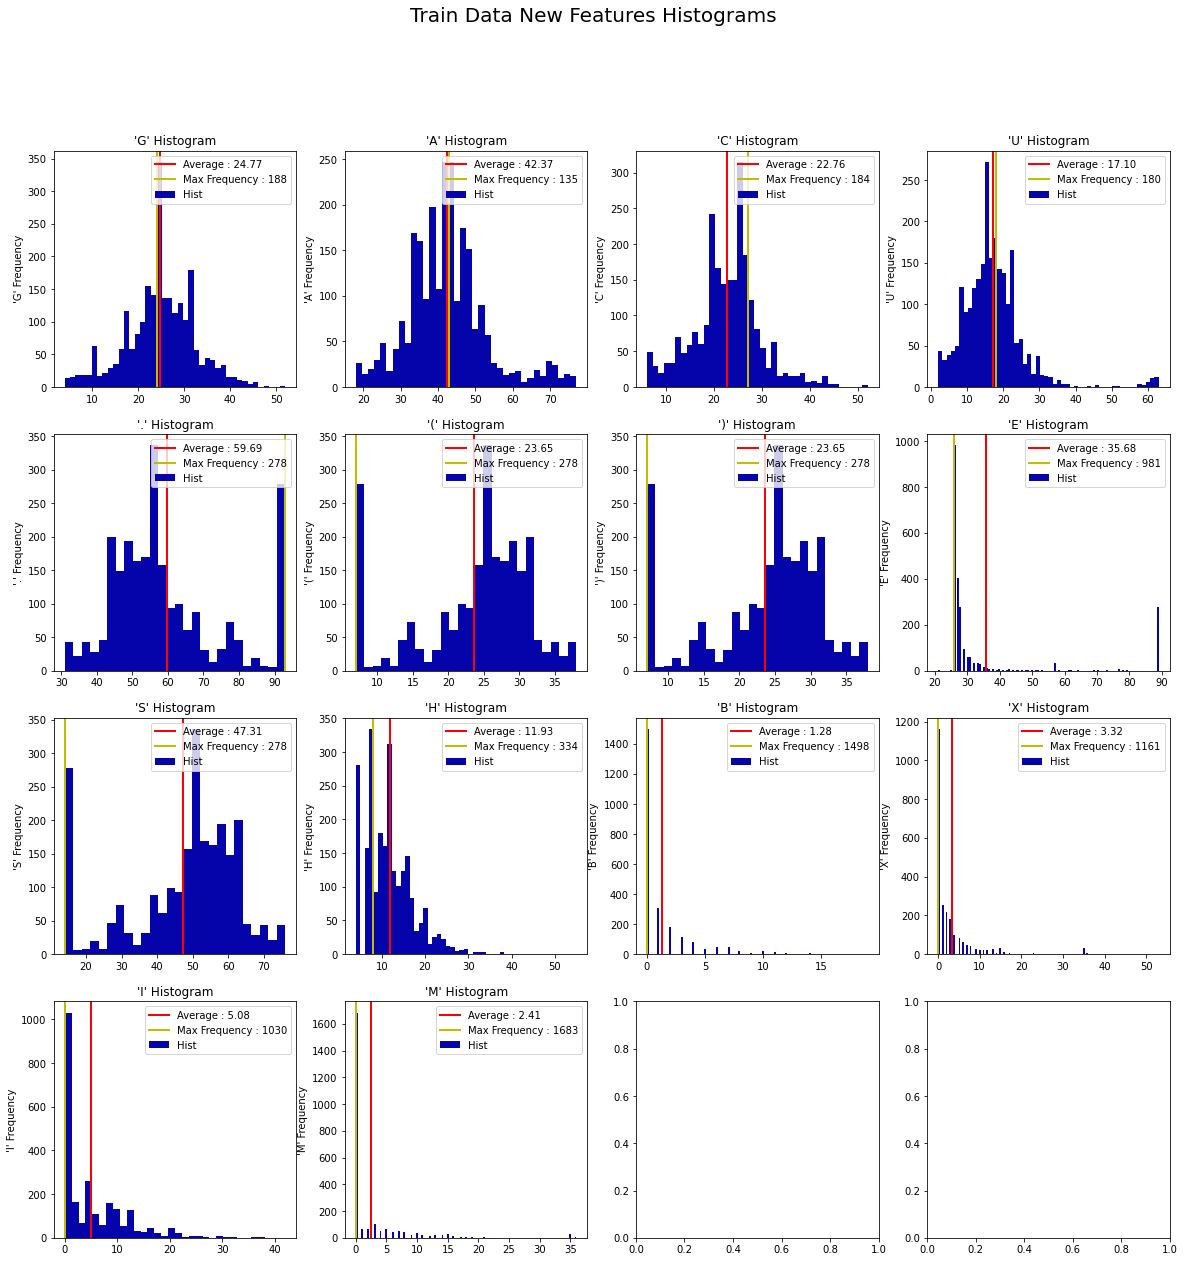

In [16]:
fig, _ax = plt.subplots(nrows=4,ncols=4,figsize=(20,20))
fig.suptitle("Train Data New Features Histograms", fontsize=20,)
for i,_ax in enumerate(_ax.ravel()[:14]):
    mean_value = train_df[feature_columns[i]].mean()
    max_value_index,max_value = Counter(train_df[feature_columns[i]]).most_common(1)[0]
    
    _ax.hist(x=train_df[feature_columns[i]],bins='auto', color='#0504aa', alpha=1, rwidth=1)
    _ax.set(ylabel=f"'{feature_columns[i]}' Frequency", title= f"'{feature_columns[i]}' Histogram")
    _ax.axvline(x=mean_value, color='r', label= 'Average',linewidth=2)
    _ax.axvline(x=max_value_index, color='y', label= 'Max',linewidth=2)
    _ax.legend([f"Average : {mean_value:0.2f}",f"Max Frequency : {max_value}", "Hist"], loc ="upper right")
plt.show()

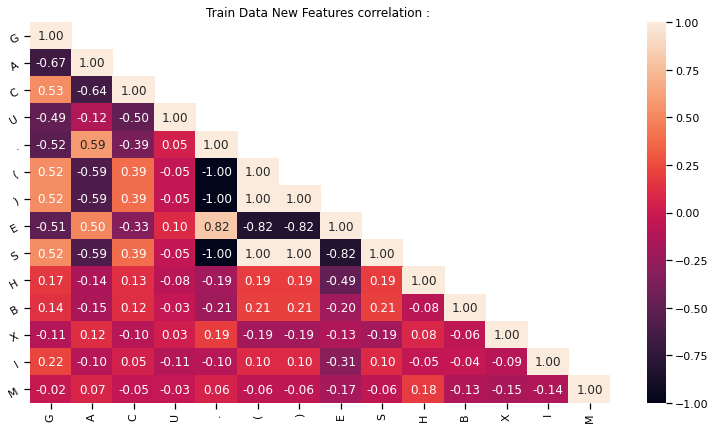

In [17]:
# Train Data New Features correlation
corr = train_df[feature_columns].corr()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(13,7))
plt.title("Train Data New Features correlation : ")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(corr,mask=mask, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

### 🤷‍♂️: '**E**', '**S**' , '**)**' , '**(**'  are highly correlated

In [18]:
## Test-Data
feature_columns = ['G','A', 'C', 'U', '.', '(', ')', 'E', 'S', 'H', 'B', 'X','I','M']
test_df[feature_columns] = test_df.apply(character_count,axis=1,result_type="expand")

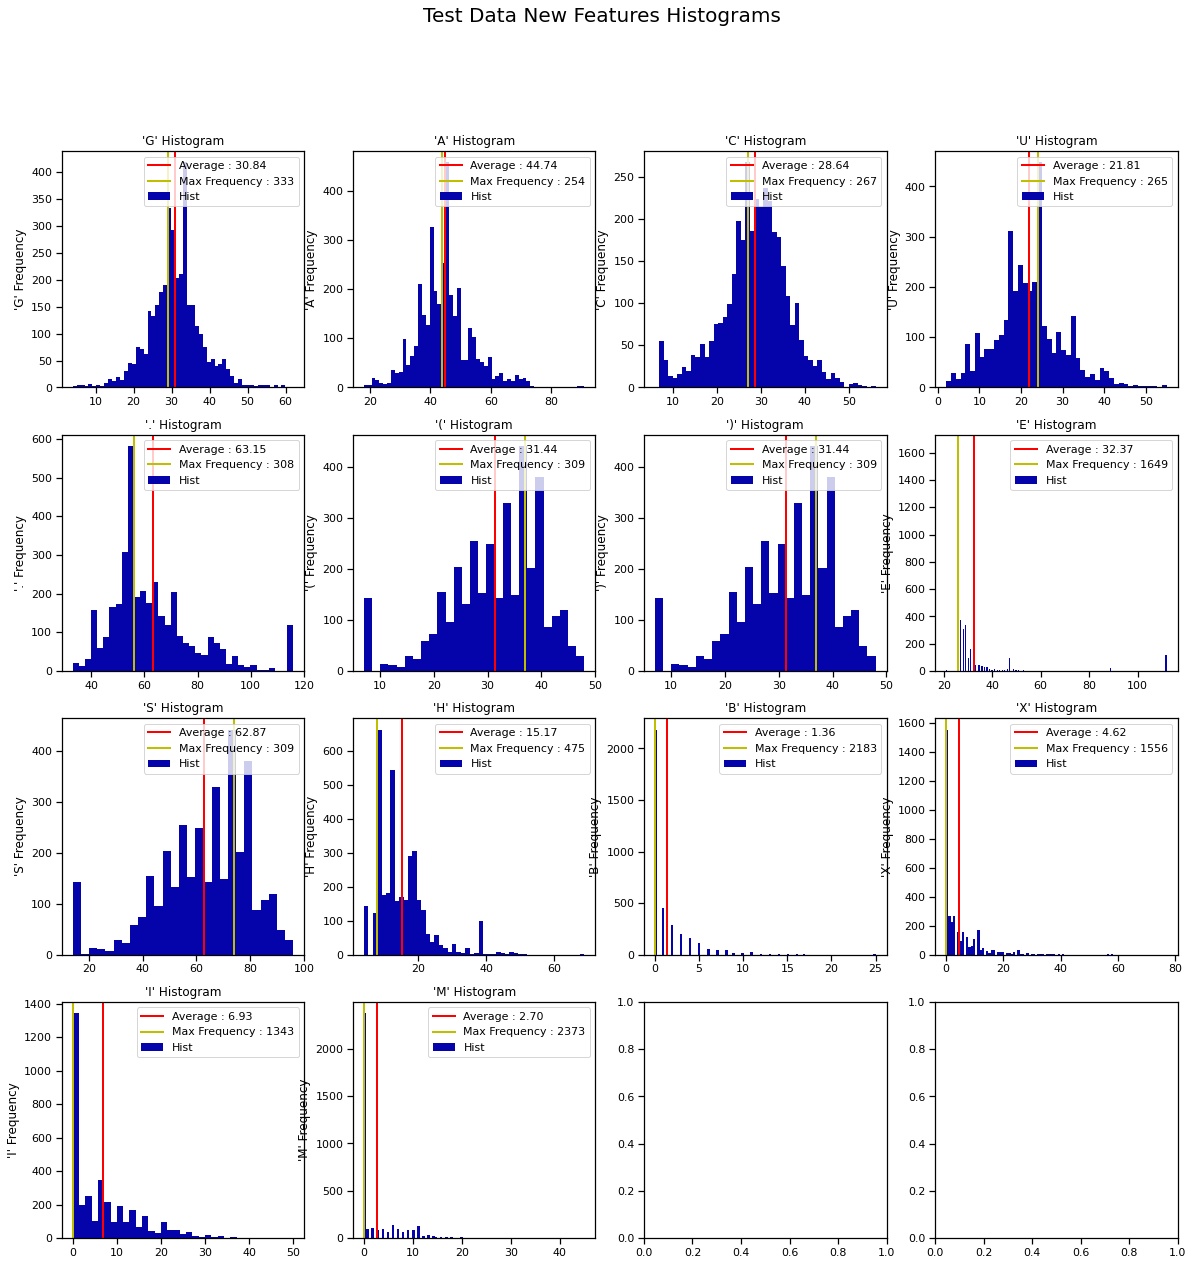

In [19]:
fig, _ax = plt.subplots(nrows=4,ncols=4,figsize=(20,20))
fig.suptitle("Test Data New Features Histograms", fontsize=20,)
for i,_ax in enumerate(_ax.ravel()[:14]):
    mean_value = test_df[feature_columns[i]].mean()
    max_value_index,max_value = Counter(test_df[feature_columns[i]]).most_common(1)[0]
    
    _ax.hist(x=test_df[feature_columns[i]],bins='auto', color='#0504aa', alpha=1, rwidth=1)
    _ax.set(ylabel=f"'{feature_columns[i]}' Frequency", title= f"'{feature_columns[i]}' Histogram")
    _ax.axvline(x=mean_value, color='r', label= 'Average',linewidth=2)
    _ax.axvline(x=max_value_index, color='y', label= 'Max',linewidth=2)
    _ax.legend([f"Average : {mean_value:0.2f}",f"Max Frequency : {max_value}", "Hist"], loc ="upper right")
plt.show()

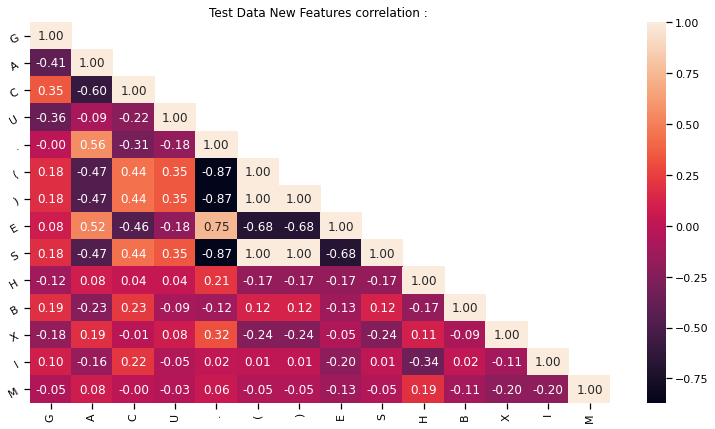

In [20]:
# Test Data New Features correlation
corr = test_df[feature_columns].corr()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(13,7))
plt.title("Test Data New Features correlation : ")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(corr,mask=mask, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

### 🤷‍♂️ unlike training data 'E' is not highly correlated with '(' , ')'.

---

## RNA Detailed Analysis 🧬 

### Example-1 (from Train data)

In [21]:
Select_id = "id_001f94081"

In [22]:
Sequence = train_df[train_df['id'] == Select_id]["sequence"].values[0]
structure = train_df[train_df['id'] == Select_id]["structure"].values[0]
predicted_loop_type = train_df[train_df['id'] == Select_id]["predicted_loop_type"].values[0]
print("Sequence :",Sequence)
print("structure :",structure)
print("predicted_loop_type :",predicted_loop_type)

Sequence : GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUAACUGGAAUAACCCAUACCAGCAGUUAGAGUUCGCUCUAACAAAAGAAACAACAACAACAAC
structure : .....((((((.......)))).)).((.....((..((((((....))))))..)).....))....(((((((....))))))).....................
predicted_loop_type : EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHHHSSSSSSIISSIIIIISSXXXXSSSSSSSHHHHSSSSSSSEEEEEEEEEEEEEEEEEEEEE


## Visualize RNA-2D Structure

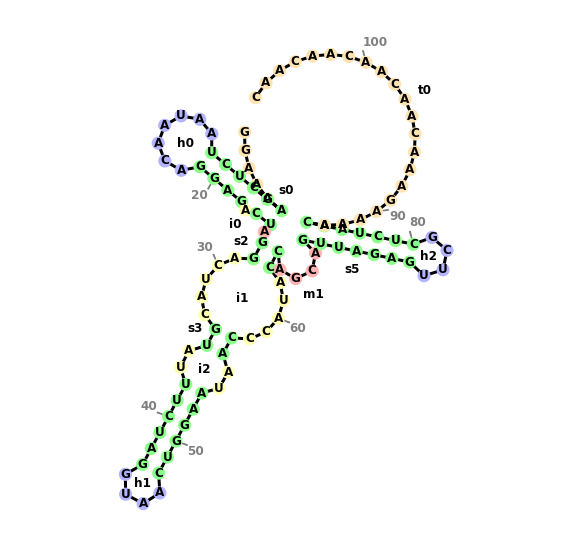

In [23]:
bg, = bulge_graph.BulgeGraph.from_fasta_text('>seq\n' + Sequence + '\n' + structure)

plt.figure(figsize=(10,10))
fvm.plot_rna(bg, text_kwargs={"fontweight":"black"}, lighten=0.7,
             backbone_kwargs={"linewidth":3})
plt.show()

## Method for Graph Representation of RNA structure

* In 2D-Visualization it is difficult to picture which section is which part of RNA. To make it easier, we will generate a Graph Structure. The neato method can take that as input and create a nice visualization of the graph:

In [24]:
def render_neato(s, format='png', dpi=100):
    p = subprocess.Popen(['neato', '-T', format, '-o', '/dev/stdout', '-Gdpi={}'.format(dpi)], 
                         stdout=subprocess.PIPE, stdin=subprocess.PIPE)
    image, _ = p.communicate(bytes(s, encoding='utf-8'))
    return image

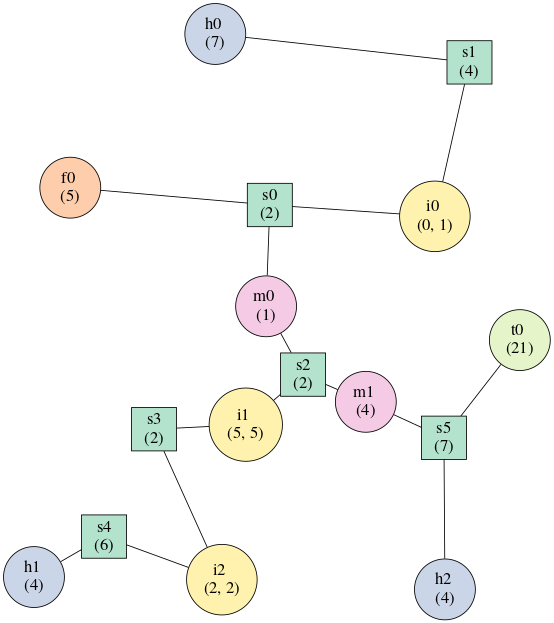

In [25]:
Image(render_neato(bg.to_neato_string(), dpi=60), format='png')

---

* **fiveprime**: The unpaired nucleotides at the 5’ end of a molecule/ chain. Name always starts with ‘f’ (e.g. ‘f0’).
* **threeprime**: The unpaired nucleotides at the 3’ end of a molecule/ chain. Name always start with ‘t’ (e.g. ‘t0’)

* **stem**: Regions of contiguous canonical Watson-Crick base-paired nucleotides. By default, stems have at least 2 consecutive basepairs. Always start with ‘s’ (e.g., ‘s0’, ‘s1’, ‘s2’, …)

* **interior loop**: Bulged out nucleotides and interior loops. An interior loop can contain unpaired bases on either strand or on both strands, flanked by stems on either side. Always start with ‘i’ (‘i0’, ‘i1’, ‘i2’,…)

* **multiloop segment**: Single-stranded regions bewteen two stems. Always start with ‘m’. (‘m0’, ‘m1’, ‘m2’…)
    In the current version of forgi, pseudo-knots and exterior loops segments between stems are treated as multiloop segments.

* **hairpin loop**: Always starts with ‘h’.


## Generating Graph Matrices from the Structures
   * [Referance](https://www.kaggle.com/theoviel/generating-graph-matrices-from-the-structures)

In [26]:
def get_couples(structure):
    """
    For each closing parenthesis, I find the matching opening one and store their index in the couples list.
    The assigned list is used to keep track of the assigned opening parenthesis
    """
    opened = [idx for idx, i in enumerate(structure) if i == '(']
    closed = [idx for idx, i in enumerate(structure) if i == ')']

    assert len(opened) == len(closed)


    assigned = []
    couples = []

    for close_idx in closed:
        for open_idx in opened:
            if open_idx < close_idx:
                if open_idx not in assigned:
                    candidate = open_idx
            else:
                break
        assigned.append(candidate)
        couples.append([candidate, close_idx])
        
    assert len(couples) == len(opened)
    
    return couples

In [27]:
def build_matrix(couples, size):
    mat = np.zeros((size, size))
    
    for i in range(size):  # neigbouring bases are linked as well
        if i < size - 1:
            mat[i, i + 1] = 1
        if i > 0:
            mat[i, i - 1] = 1
    
    for i, j in couples:
        mat[i, j] = 1
        mat[j, i] = 1
        
    return mat

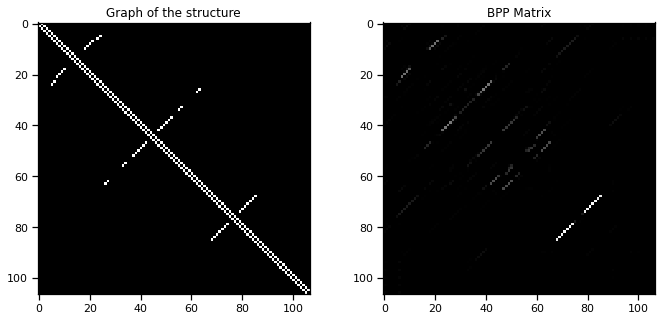

In [28]:
couples = get_couples(structure)
mat = build_matrix(couples, len(structure))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11.35, 5))

im = axes[0].imshow(mat, interpolation='none',cmap='gray')
axes[0].set_title('Graph of the structure')
# axes[0].pcolormesh(adj_mat, )

bpp = np.load(path +f"/bpps/{Select_id}.npy")

im = axes[1].imshow(bpp, interpolation='none',cmap='gray')
axes[1].set_title('BPP Matrix')

plt.show()

### Example-2 (Test Data)

In [29]:
Select_id = "id_000ae4237"

In [30]:
Sequence = test_df[test_df['id'] == Select_id]["sequence"].values[0]
structure = test_df[test_df['id'] == Select_id]["structure"].values[0]
predicted_loop_type = test_df[test_df['id'] == Select_id]["predicted_loop_type"].values[0]
print("Sequence :",Sequence)
print("structure :",structure)
print("predicted_loop_type :",predicted_loop_type)

Sequence : GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAUGCAGCUACCGGCUCUAUAAUGAGCAAAAACGGUAAAUCCCGACAAGCUUGAUUUCGAUCAAGCAAAAGAAACAACAACAACAAC
structure : .....((((..((((((...(((((.....((((....))))....)))))..)))((((......)))).....))).....))))....(((((((....))))))).....................
predicted_loop_type : EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIIISSSSSIISSSSSSSHHHHHHSSSSMMMMMSSSIIIIISSSSXXXXSSSSSSSHHHHSSSSSSSEEEEEEEEEEEEEEEEEEEEE


## Visualize RNA-2D Structure

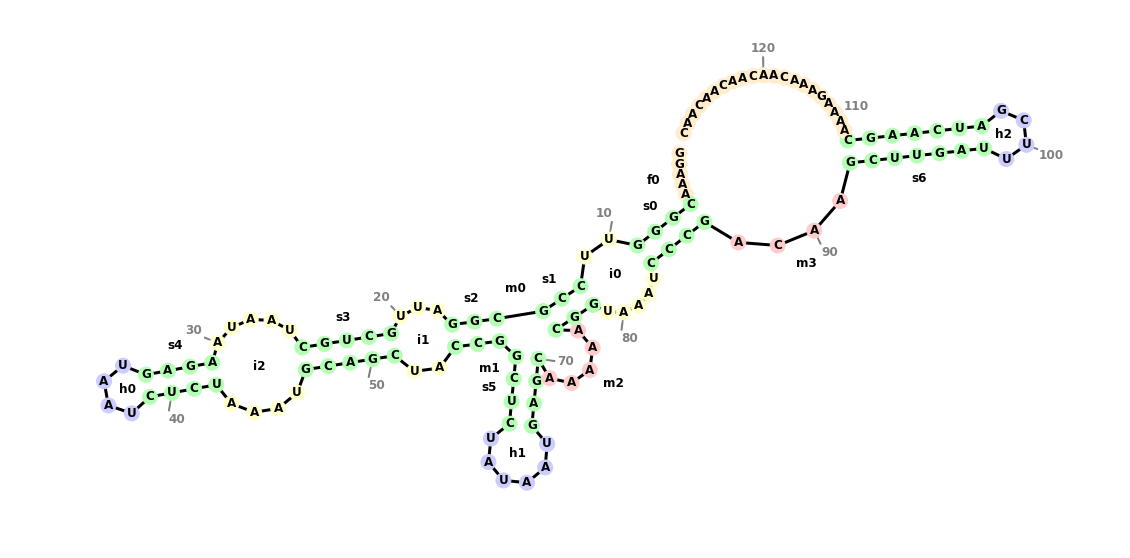

In [31]:
bg, = bulge_graph.BulgeGraph.from_fasta_text('>seq\n' + Sequence + '\n' + structure)

plt.figure(figsize=(20,10))
fvm.plot_rna(bg, text_kwargs={"fontweight":"black"}, lighten=0.8,
             backbone_kwargs={"linewidth":3})
plt.show()

## Graph Representation of RNA structure

In [32]:
def render_neato(s, format='png', dpi=100):
    p = subprocess.Popen(['neato', '-T', format, '-o', '/dev/stdout', '-Gdpi={}'.format(dpi)], 
                         stdout=subprocess.PIPE, stdin=subprocess.PIPE)
    image, _ = p.communicate(bytes(s, encoding='utf-8'))
    return image

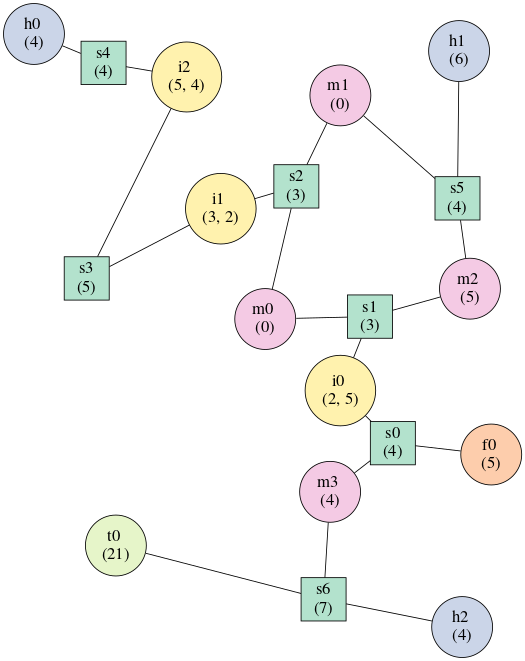

In [33]:
Image(render_neato(bg.to_neato_string(), dpi=60), format='png')

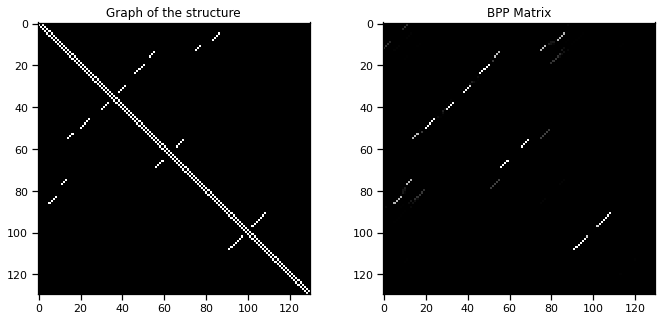

In [34]:
couples = get_couples(structure)
mat = build_matrix(couples, len(structure))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11.35, 5))

im = axes[0].imshow(mat, interpolation='none',cmap='gray')
axes[0].set_title('Graph of the structure')

bpp = np.load(path +f"/bpps/{Select_id}.npy")

im = axes[1].imshow(bpp, interpolation='none',cmap='gray')
axes[1].set_title('BPP Matrix')

plt.show()